In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point
from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model


import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
scaler = StandardScaler()

In [35]:
clean_data = pd.read_csv('data/Ames_HousePrice_cleaned.csv')
address_data = pd.read_csv('data/Ames_HousePrice_Address.csv')

clean_data = clean_data.merge(address_data[['PID', 'Longitude', 'Latitude']], on = 'PID')
clean_data = clean_data[~clean_data['Longitude'].isna()].copy()
clean_data_cluster = clean_data[['Longitude', 'Latitude']]

mainlocs = {"LincolnGrand" : (42.0228613,-93.6202381),
            "LincolnSD" : (42.0229155,-93.6786829),
            "OntarioND" : (42.034549,-93.6787169),
            "Grand13" : (42.0345358,-93.6203941),
            "Grand24" : (42.0457363,-93.6205019),
            "GWHarrison" : (42.0594753,-93.6592406),
            "BloomStange" : (42.0563395,-93.6448835),
            "IC3069" : (42.0049608,-93.609927)}

for kw, val in mainlocs.items():
    clean_data['dist_%s' %kw] = clean_data.apply(lambda x: distance.distance((x.loc['Latitude'],x.loc['Longitude']), val).miles, axis = 1)

In [36]:
# scaled_features = scaler.fit_transform(clean_data_cluster)
# kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42)
# kmeans.fit(scaled_features)
# clean_data['cluster'] = kmeans.labels_
# clean_data.to_csv('x_new.csv',index=False)

In [37]:
clean_data = clean_data[~clean_data['Longitude'].isna()]
cl_y = clean_data['SalePrice']
cl_x = clean_data.drop(['PID','SalePrice','LandContour','PavedDrive'], axis = 1)

cl_x_dummies = pd.get_dummies(cl_x, columns=['MSSubClass','MSZoning','LotShape',\
        'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle','MasVnrType', 'ExterQual', \
        'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
       'HeatingQC','CentralAir','KitchenQual','GarageType','SaleCondition','Electrical'],\
        prefix=['mssc','msz','ls',\
                'lcf','nghbr','bt','hs','mvt','eq',\
                'ec','f','bq','bc','be','bf1','bf2',\
               'hq','ca','kq','gt','sc','el'], prefix_sep='_',drop_first=True)
               
cl_x_dummies = cl_x_dummies.fillna(0)

# print(cl_x_dummies.shape)
# print(cl_y.shape)
trainscore = []
testscore = []

for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(cl_x_dummies, cl_y, test_size=0.3, random_state=i, shuffle=True)
        # X_train.to_csv('x_train_dummies.csv',index=False)
        # y_train.to_csv('y_train_dummies.csv',index=False)
        # X_test.to_csv('x_test_dummies.csv',index=False)
        # y_test.to_csv('y_test_dummies.csv',index=False)

        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model  = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
        model.set_params(normalize=True)
        model.fit(X_train, y_train)

        trainscore.append(model.score(X_train, y_train))
        testscore.append(model.score(X_test, y_test))
        
        coefs  = model.coef_.T
        beta = list(zip(X_train.columns.to_list(), coefs))

avetrainscore = np.mean(trainscore)
avetestscore = np.mean(testscore)



In [38]:
clean_data['residual'] = cl_y - model.predict(cl_x_dummies)

(array([ 2.,  5.,  4.,  5.,  2.,  1.,  3.,  5., 14.,  9.]),
 array([0.85490745, 0.86247038, 0.87003331, 0.87759624, 0.88515917,
        0.8927221 , 0.90028503, 0.90784797, 0.9154109 , 0.92297383,
        0.93053676]),
 <BarContainer object of 10 artists>)

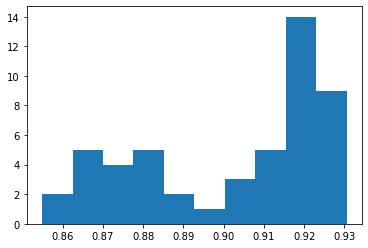

In [39]:
plt.hist(testscore, bins = 10)

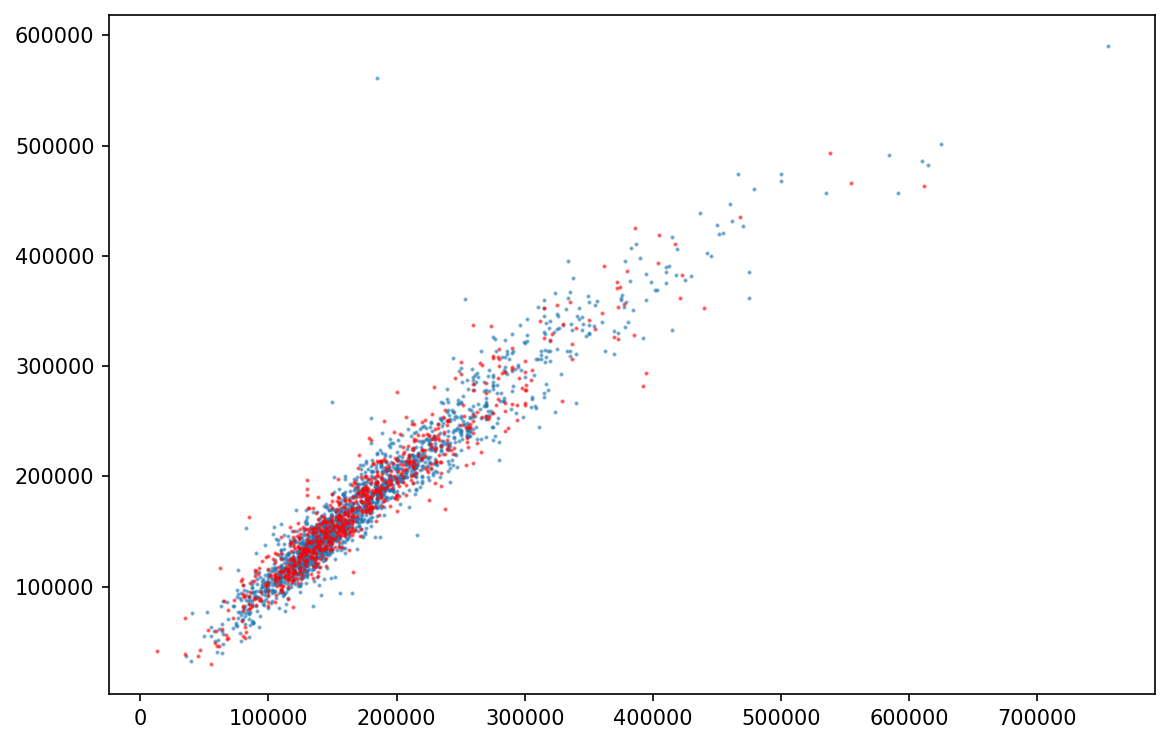

In [40]:
plt.figure(figsize=(9, 6), dpi=150)
plt.scatter(y_train,model.predict(X_train), alpha = 0.5, s = 1)
plt.scatter(y_test,model.predict(X_test), alpha = 0.5, s = 1, color = 'red')

<GeoAxesSubplot:>

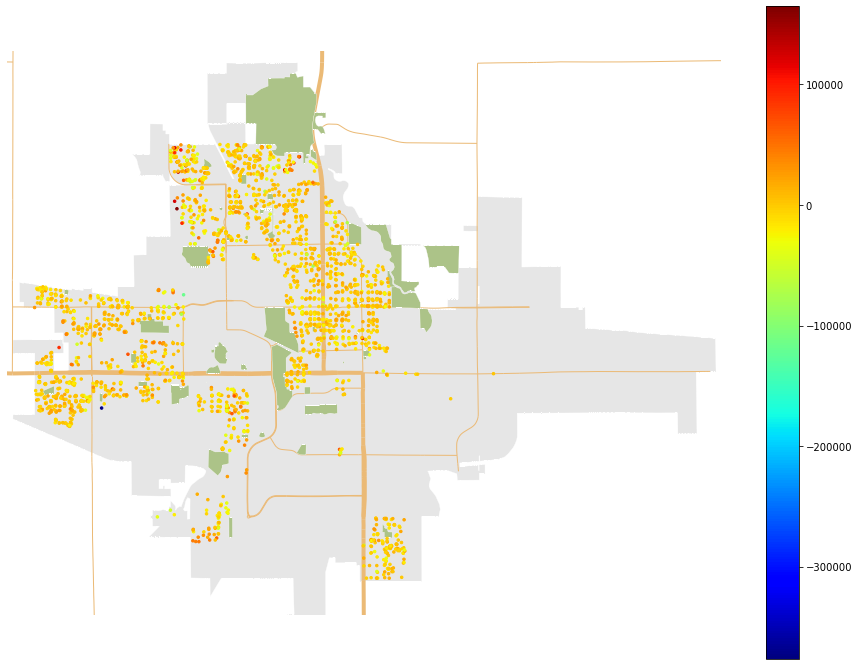

In [41]:
housing = clean_data
city = gpd.read_file("data/city.geojson")
roads = gpd.read_file("data/roads.geojson")
park = gpd.read_file("data/park.geojson")
houses = housing.apply(
    lambda srs: Point(float(srs['Longitude']), float(srs['Latitude'])),
    axis='columns'
)
roads_df = roads[['highway','geometry']]
roads_primary = roads_df[roads_df['highway']=='primary']
roads_secondary = roads_df[roads_df['highway']=='secondary']
# roads_tertiary = roads_df[roads_df['highway']=='tertiary']
# roads_residential = roads_df[roads_df['highway']=='residential']
housing['pps'] = housing['SalePrice']/housing['GrLivArea']
houses_geocode = gpd.GeoDataFrame(housing, geometry=houses)

ax = geoplot.polyplot(city, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#e6e6e6', linewidth=.3, figsize=(16, 12))
geoplot.polyplot(roads_primary, edgecolor='#ebba76', linewidth=4, ax = ax)
geoplot.polyplot(roads_secondary, edgecolor='#ebba76', linewidth=1, ax = ax)
# geoplot.polyplot(roads_tertiary, edgecolor='white', linewidth=1, ax = ax)
# geoplot.polyplot(roads_residential, edgecolor='white', linewidth=0.25, ax = ax)
geoplot.pointplot(houses_geocode, hue='residual',cmap = 'jet', marker = '.', s = 5, legend=True, ax=ax)
geoplot.polyplot(park, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#acc388', linewidth=.3, ax=ax, extent=( -93.70,41.98, -93.52, 42.08))